In [57]:
"""
!pip uninstall autogluon --yes
!pip uninstall scikit-learn --yes
!pip install scikit-learn==1.4.0
!pip install autogluon
"""

'\n!pip uninstall autogluon --yes\n!pip uninstall scikit-learn --yes\n!pip install scikit-learn==1.4.0\n!pip install autogluon\n'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss

#from autogluon.tabular import TabularPredictor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda  x: '%.3f' % x)
pd.set_option('display.width', 500)

In [4]:
df_train = pd.read_csv("/kaggle/input/bank-churn/train.csv")
df_test = pd.read_csv("/kaggle/input/bank-churn/train.csv")

In [5]:
X = df_train.drop(["id", "CustomerId", "Surname", "Exited"], axis=1)
y = df_train["Exited"]
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.15, random_state=42)

In [6]:
def check_df(dataframe, head=5):
    print("############################################")
    print(dataframe.shape)
    print("############################################")
    print(dataframe.dtypes)
    print("############################################")
    print(dataframe.nunique())
    print("############################################")
    print(dataframe.head(head))
    print("############################################")
    print(dataframe.tail(head))
    print("############################################")
    print(dataframe.isnull().sum())
    
check_df(X_train)

############################################
(115523, 10)
############################################
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
dtype: object
############################################
CreditScore          455
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            23276
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    42898
dtype: int64
############################################
        CreditScore Geography  Gender    Age  Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary
76047           524     Spain    Male 45.000       6      0.000              2      1.000           0.000       132861.900
57212         

In [7]:
def create_col_type(dataframe, threshold_cat=11, threshold_car=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    
    cat_but_car = [col for col in dataframe.columns if ((dataframe[col].dtypes == 'O') 
                                                        and (dataframe[col].nunique() > threshold_car))]
    num_but_cat = [col for col in dataframe.columns if ((dataframe[col].dtypes !='O') 
                                                        and (dataframe[col].nunique() <= threshold_cat))]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes !='O']
    num_cols = [col for col in num_cols if col not in num_but_cat]
    

    return cat_cols, num_cols, cat_but_car

cat_cols_train, num_cols_train, cat_but_car_train = create_col_type(X_train)
cat_cols_val, num_cols_val, cat_but_car_val = create_col_type(X_val)
cat_cols_test, num_cols_test, cat_but_car_test = create_col_type(X_test)

In [8]:
def Impute_missing_data(dataframe):
    for col in num_cols_train:
        dataframe.loc[dataframe[col].isnull(), col] = dataframe[col].median()
    for col in cat_cols_train:
        dataframe.loc[dataframe[col].isnull(), col] = "Unk"
    return dataframe


X_train = Impute_missing_data(X_train)
X_val = Impute_missing_data(X_val)
X_test = Impute_missing_data(X_test)

<ipython-input-8-4a0d0ead778e>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unk' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[dataframe[col].isnull(), col] = "Unk"
<ipython-input-8-4a0d0ead778e>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unk' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dataframe.loc[dataframe[col].isnull(), col] = "Unk"
<ipython-input-8-4a0d0ead778e>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Unk' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[dataframe[col].isnull(), col] = "Unk"
<ipython-input-8-4a0d0ead778e>:5: FutureWarning: Setting an item of incompatible dtype is deprecated and

In [9]:
def Impute_outlier_data(dataframe, q1=0.15, q3=0.85):
    for col in num_cols_train:
        dataframe[col] = dataframe[col].astype(float)
        quartile_1 = dataframe[col].quantile(q1)
        quartile_3 = dataframe[col].quantile(q3)
        inter_quantile = quartile_3 - quartile_1

        low_limit = quartile_1 - 1.5 * inter_quantile
        upp_limit = quartile_3 + 1.5 * inter_quantile

        dataframe.loc[(dataframe[col] < low_limit), col] = low_limit
        dataframe.loc[(dataframe[col] > upp_limit), col] = upp_limit
        return dataframe

X_train = Impute_outlier_data(X_train)
X_val = Impute_outlier_data(X_val)
X_test = Impute_outlier_data(X_test)

In [10]:
def feature_engineering(dataframe):

    dataframe.loc[(dataframe["HasCrCard"]==1) & (dataframe["IsActiveMember"]==1), 
                        "NEW_ACTİVE_CARD"] = "active_card"
    dataframe.loc[(dataframe["HasCrCard"]==1) & (dataframe["IsActiveMember"]==0), 
                       "NEW_ACTİVE_CARD"] = "inactive_card"
    dataframe.loc[(dataframe["HasCrCard"]==0) & (dataframe["IsActiveMember"]==1), 
                       "NEW_ACTİVE_CARD"] = "active_notcard"
    dataframe.loc[(dataframe["HasCrCard"]==0) & (dataframe["IsActiveMember"]==0), 
                       "NEW_ACTİVE_CARD"] = "inactive_notcard"

    dataframe.loc[dataframe["Balance"] >= dataframe["EstimatedSalary"], "NEW_IS_INVESTOR"] = "investor"
    dataframe.loc[dataframe["Balance"] < dataframe["EstimatedSalary"], "NEW_IS_INVESTOR"] = "not_investor"

    dataframe.loc[(dataframe["Age"] >= 18) & (dataframe["Age"] < 30), "NEW_AGE_CAT"] = "young"
    dataframe.loc[(dataframe["Age"] >= 30) & (dataframe["Age"] < 50), "NEW_AGE_CAT"] = "mature"
    dataframe.loc[dataframe["Age"] >= 50, "NEW_AGE_CAT"] = "senior"

    dataframe.loc[(dataframe["Geography"] == "France") & (dataframe["NEW_IS_INVESTOR"] == "investor"), 
                       "NEW_IS_GEOGRAPHY_INVESTOR"] = "french_investor"
    dataframe.loc[(dataframe["Geography"] == "Spain") & (dataframe["NEW_IS_INVESTOR"] == "investor"), 
                       "NEW_IS_GEOGRAPHY_INVESTOR"] = "spanish_investor"
    dataframe.loc[(dataframe["Geography"] == "Germany") & (dataframe["NEW_IS_INVESTOR"] == "investor"), 
                       "NEW_IS_GEOGRAPHY_INVESTOR"] = "german_investor"
    dataframe.loc[(dataframe["Geography"] == "France") & (dataframe["NEW_IS_INVESTOR"] == "not_investor"), 
                       "NEW_IS_GEOGRAPHY_INVESTOR"] = "french_not_investor"
    dataframe.loc[(dataframe["Geography"] == "Spain") & (dataframe["NEW_IS_INVESTOR"] == "not_investor"), 
                       "NEW_IS_GEOGRAPHY_INVESTOR"] = "spanish_not_investor"
    dataframe.loc[(dataframe["Geography"] == "Germany") & (dataframe["NEW_IS_INVESTOR"] == "not_investor"), 
                       "NEW_IS_GEOGRAPHY_INVESTOR"] = "german_not_investor"

    dataframe.loc[(dataframe["CreditScore"] < 489), 
                    "NEW_CREDİTSCORE_CAT"] = "very_risky"
    dataframe.loc[(dataframe["CreditScore"] >= 489) & (dataframe["CreditScore"] < 599),
                    "NEW_CREDİTSCORE_CAT"] = "risky"
    dataframe.loc[(dataframe["CreditScore"] >= 599) & (dataframe["CreditScore"] < 704), 
                    "NEW_CREDİTSCORE_CAT"] = "normal"
    dataframe.loc[(dataframe["CreditScore"] >= 704) & (dataframe["CreditScore"] < 812), 
                    "NEW_CREDİTSCORE_CAT"] = "not_risky"
    dataframe.loc[(dataframe["CreditScore"] >= 812), 
                    "NEW_CREDİTSCORE_CAT"] = "very_not_risky"
    
    return dataframe

X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)
X_test = feature_engineering(X_test)

In [11]:
def ordinalencoding(dataframe, train=True):
    investor_size = ['not_investor', 'investor']
    age_cat_size = ['young', 'mature', 'senior']
    credi_score_size = ['very_risky', 'risky', 'normal', 'not_risky', 'very_not_risky']

    enc = OrdinalEncoder(categories=[investor_size, age_cat_size, credi_score_size])
    columns_to_encode = ["NEW_IS_INVESTOR", "NEW_AGE_CAT", "NEW_CREDİTSCORE_CAT"]
    if train:
        dataframe[columns_to_encode] = enc.fit_transform(dataframe[columns_to_encode])
        joblib.dump(enc, 'ordinal_encoder.pkl')
    else:
        loaded_encoder = joblib.load('ordinal_encoder.pkl')
        dataframe[columns_to_encode] = loaded_encoder.transform(dataframe[columns_to_encode])
    return dataframe


X_train = ordinalencoding(X_train)
X_val = ordinalencoding(X_val, train=False)
X_test = ordinalencoding(X_test, train=False)

In [12]:
def onehotencoding(dataframe, train=True):
    cat_cols, num_cols, cat_but_car = create_col_type(dataframe)
    one_hot_cat_cols = [col for col in cat_cols if col not in ["NEW_IS_INVESTOR", "NEW_AGE_CAT", "NEW_CREDİTSCORE_CAT"]]
    
    if train:
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
        encoded_cols = ohe.fit_transform(dataframe[one_hot_cat_cols])
        joblib.dump(ohe, 'one_hot_encoder.pkl')
        new_columns = ohe.get_feature_names_out(one_hot_cat_cols)
        encoded_df = pd.DataFrame(encoded_cols, columns=new_columns, index=dataframe.index)
        dataframe = pd.concat([dataframe, encoded_df], axis=1)
        dataframe.drop(columns=one_hot_cat_cols, inplace=True)
    else:
        loaded_ohe = joblib.load('one_hot_encoder.pkl')
        encoded_test_data = loaded_ohe.transform(dataframe[one_hot_cat_cols])
        new_columns = loaded_ohe.get_feature_names_out(one_hot_cat_cols)
        encoded_test_df = pd.DataFrame(encoded_test_data, columns=new_columns, index=dataframe.index)
        dataframe = pd.concat([dataframe, encoded_test_df], axis=1)
        dataframe.drop(columns=one_hot_cat_cols, inplace=True)
    
    return dataframe

X_train = onehotencoding(X_train)
X_val = onehotencoding(X_val, train=False)
X_test = onehotencoding(X_test, train=False)

In [13]:
def undersampling(dataframe, y):
    X_train, y_train = NearMiss().fit_resample(dataframe, y)
    return X_train, y_train

X_train, y_train = undersampling(X_train, y_train)

In [14]:
def normalization(dataframe, train=True):
    cat_cols, num_cols, cat_but_car = create_col_type(dataframe)

    if train:
        scaler = StandardScaler()
        dataframe[num_cols] = scaler.fit_transform(dataframe[num_cols])
        joblib.dump(scaler, 'standardscaler.pkl')
    else:
        loaded_scaler = joblib.load('standardscaler.pkl')
        dataframe[num_cols] = loaded_scaler.transform(dataframe[num_cols])

    return dataframe

X_train = normalization(X_train)
X_val = normalization(X_val, train=False)
X_test = normalization(X_test, train=False)

In [15]:
def prediction(model_name,model, X, y_true):
    y_pred = model.predict(X)
    
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['True 0', 'True 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} confusion matrix')
    plt.show()

In [115]:
def xgboost_model(X_train, y_train):
    xgboost_model = XGBClassifier()
    cv_results = cross_validate(xgboost_model,
                               X_train,
                               y_train,
                               cv=5,
                               scoring=["accuracy", "f1", "roc_auc"])
    
    print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
    print(f"test_f1 \n {cv_results['test_f1'].mean()}")
    print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

xgboost_model(X_train, y_train)

test_accuracy 
 0.9034351384460708
test_f1 
 0.9028739098648911
test_roc_auc 
 0.9628261116781642


In [83]:
def GridSearch_xgboost(X_train, y_train):
    xgboost_params = {"learning_rate": [0.001, 0.01, 0.1],
                  "max_depth": [5, 8, None],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [None, 0.7, 1],
                  "device" : ['cuda']}
    
    xgboost_model2 = XGBClassifier()
    xgboost_best_grid = GridSearchCV(xgboost_model2,
                                 xgboost_params,
                                 cv=5,
                                 n_jobs=1,
                                 verbose=True).fit(X_train, y_train)
    print(f"Best params : {xgboost_best_grid.best_params_}")

GridSearch_xgboost(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [17]:
def xgboost_final_model(X_train, y_train):
    xgboost_best_params = {
        "learning_rate": 0.01,
        "max_depth": 5,
        "n_estimators": 1000,
        "colsample_bytree": 0.7,
        "device": "cuda"
        }
    
    xgboost_final = XGBClassifier(**xgboost_best_params).fit(X_train, y_train)
    cv_results = cross_validate(xgboost_final,
                                X_train,
                                y_train,
                                cv=5,
                                scoring=["accuracy", "f1", "roc_auc"])
    
    print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
    print(f"test_f1 \n {cv_results['test_f1'].mean()}")
    print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")
    
    return xgboost_final

xgboost_final = xgboost_final_model(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:47:27] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


test_accuracy 
 0.9062668632677944
test_f1 
 0.9054171975409837
test_roc_auc 
 0.9654513850614711


              precision    recall  f1-score   support

           0       0.95      0.51      0.66     33223
           1       0.33      0.90      0.48      8861

    accuracy                           0.59     42084
   macro avg       0.64      0.70      0.57     42084
weighted avg       0.82      0.59      0.62     42084



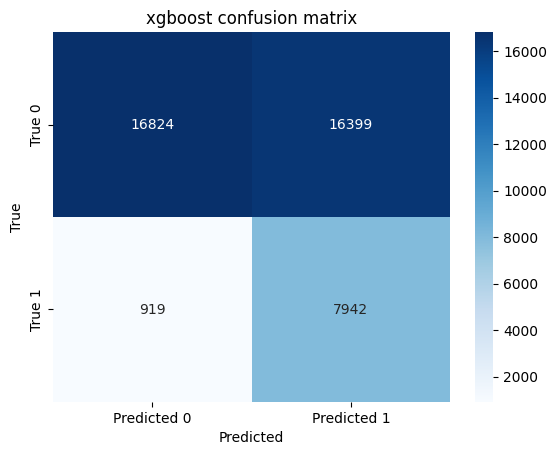

In [27]:
prediction("xgboost", xgboost_final, X_val, y_val)

In [25]:
def lightgbm_model(X_train, y_train):
    lgbm_model = LGBMClassifier(verbosity = -1)
    cv_results = cross_validate(lgbm_model,
                               X_train,
                               y_train,
                               cv=5,
                               scoring=["accuracy", "f1", "roc_auc"])
    
    print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
    print(f"test_f1 \n {cv_results['test_f1'].mean()}")
    print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

lightgbm_model(X_train, y_train)

test_accuracy 
 0.9049834003411338
test_f1 
 0.9043530778439275
test_roc_auc 
 0.9650252547931817


In [24]:
def GridSearch_lgbm(X_train, y_train):
    lgbm_model_params = {
        "num_leaves": [15, 31, 63],
        "max_depth": [-1, 10, 20],
        "learning_rate": [0.01, 0.1],
        "n_estimators": [100, 200],
        "verbosity": [-1],
        "device" : ['gpu']}
    
    lgbm_model = LGBMClassifier()
    lgbm_model_best_grid = GridSearchCV(lgbm_model,
                                 lgbm_model_params,
                                 cv=5,
                                 n_jobs=1,
                                 verbose=0).fit(X_train, y_train)
    print(f"Best params : {lgbm_model_best_grid.best_params_}")

GridSearch_lgbm(X_train, y_train)

Best params : {'device': 'gpu', 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 15, 'verbosity': -1}


In [30]:
def lgbm_final_model(X_train, y_train):
    lgbm_best_params = {
        "num_leaves": 15,
        "max_depth": -1,
        "learning_rate" : 0.1,
        "n_estimators": 100,
        "verbosity" : -1,
        "device": "gpu"
        }
    
    lgbm_final = LGBMClassifier(**lgbm_best_params).fit(X_train, y_train)
    cv_results = cross_validate(lgbm_final,
                                X_train,
                                y_train,
                                cv=5,
                                scoring=["accuracy", "f1", "roc_auc"])
    
    print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
    print(f"test_f1 \n {cv_results['test_f1'].mean()}")
    print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")
    
    return lgbm_final

lgbm_final = lgbm_final_model(X_train, y_train)

test_accuracy 
 0.9057779134490364
test_f1 
 0.9049982100506793
test_roc_auc 
 0.9653449656230991


              precision    recall  f1-score   support

           0       0.95      0.51      0.66     33223
           1       0.33      0.90      0.48      8861

    accuracy                           0.59     42084
   macro avg       0.64      0.70      0.57     42084
weighted avg       0.82      0.59      0.62     42084



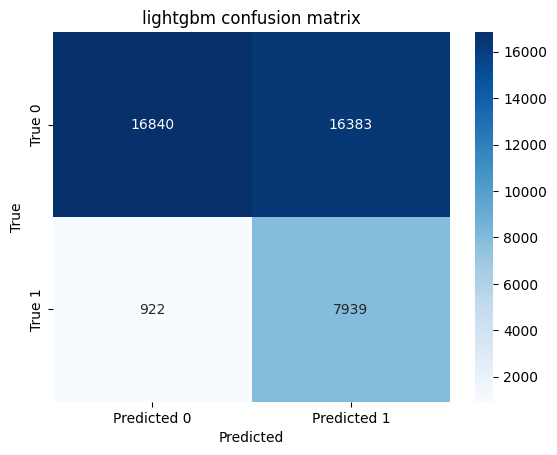

In [32]:
prediction("lightgbm", lgbm_final, X_val, y_val)

In [35]:
def catboost_model(X_train, y_train):
    catboost_model = CatBoostClassifier(verbose=False)
    cv_results = cross_validate(catboost_model,
                               X_train,
                               y_train,
                               cv=5,
                               scoring=["accuracy", "f1", "roc_auc"])
    
    print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
    print(f"test_f1 \n {cv_results['test_f1'].mean()}")
    print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")

catboost_model(X_train, y_train)

test_accuracy 
 0.9059612605527351
test_f1 
 0.9052406529627142
test_roc_auc 
 0.9651171891820939


In [ ]:
def GridSearch_catboost(X_train, y_train):
    catboost_model_params = {
        'iterations': [100, 200, 500],
        'learning_rate': [0.01, 0.05, 0.1],       
        'depth': [4, 6, 8],                        
        'bagging_temperature': [0.0, 0.5, 1.0],
        "task_type" : ['GPU']}
    
    catboost_model = CatBoostClassifier(verbose=False)
    catboost_model_best_grid = GridSearchCV(catboost_model,
                                 catboost_model_params,
                                 cv=5,
                                 n_jobs=1,
                                 verbose=0).fit(X_train, y_train)
    print(f"Best params : {catboost_model_best_grid.best_params_}")

GridSearch_catboost(X_train, y_train)

In [ ]:
def catboost_final_model(X_train, y_train):
    catboost_best_params = {
        "iterations": 15,
        "learning_rate": -1,
        "depth" : 0.1,
        "bagging_temperature": 100,
        "verbose" : False,
        "task_type": "GPU"
        }
    
    catboost_final = CatBoostClassifier(**catboost_best_params).fit(X_train, y_train)
    cv_results = cross_validate(catboost_final,
                                X_train,
                                y_train,
                                cv=5,
                                scoring=["accuracy", "f1", "roc_auc"])
    
    print(f"test_accuracy \n {cv_results['test_accuracy'].mean()}")
    print(f"test_f1 \n {cv_results['test_f1'].mean()}")
    print(f"test_roc_auc \n {cv_results['test_roc_auc'].mean()}")
    
    return catboost_final

catboost_final = catboost_final_model(X_train, y_train)